# Fitting Models to ROC Data

In [1]:
import numpy as np
from roc_models import *
import matplotlib.pyplot as plt
rc = {'font.family':'cambria', 'font.size':14}
plt.rcParams.update(rc)

### Specify data here
These two arrays are for the signal truly present and signal truly absent events.
The values correspond to each point on a decision variable scale.
The order matters: both arrays are in order from strongest "yes" through to strongest "no" classification.

In [2]:
signal = [431, 218, 211, 167, 119, 69]
noise = [102, 161, 288, 472, 492, 308]

# Transform them for plotting and other stuff. Not needed for models.
signal_roc, noise_roc = roc(signal, noise)
signal_z, noise_z = z_score(signal_roc, noise_roc)

The structure is standard for all models: 
1. initialise the model object
2. call the `Model.add_data()` method to add the data from above
3. call the `Model.optifit()` method to optimize and fit the model to the added data.

In [3]:
# Initialise models and add the origianl count data to them
HT = HighThreshold() # high threshold
HT.add_data(signal, noise) 

SDT = SignalDetection(equal_variance=True)
SDT.add_data(signal, noise)

UVSDT = SignalDetection(equal_variance=False)
UVSDT.add_data(signal, noise)

DPSDT = DualProcess()
DPSDT.add_data(signal, noise)

dDPSDT = DoubleDualProcess() # Dual process with two unequal thresholds
dDPSDT.add_data(signal, noise)

# Adjust parameters to minimize sum G^2, then run fit on optimal params
HT.optifit() 
SDT.optifit()
UVSDT.optifit()
DPSDT.optifit() 
dDPSDT.optifit() # dual process + 2 unequal threshold

See the basic outputs. Optimized decision variables not shown here since threshold model doesn't have them.

In [4]:
for m in [HT, SDT, UVSDT, DPSDT, dDPSDT]:
    print(f"{m.name} optimal parameters:\n{m.optimal_parameters}\n")

HT optimal parameters:
{'R': 0.45956516973759476}

SDT optimal parameters:
{'d': 1.0143871042304542, 'signal_var': 1.0}

UVSDT optimal parameters:
{'d': 1.1645085678330733, 'signal_var': 1.2999903055104052}

DPSDT optimal parameters:
{'R': 0.24002670369907383, 'd': 0.6912959150388527}

2DPSDT optimal parameters:
{'R': 0.08873214300159699, 'Rx': -0.32662756452171854, 'd': 1.1912972171587657}



We can also get the parameter estimates of recollection & familiarity. Naming could be a bit better because parameters also refers to things like `d` and `signal_var` depending on the model.

In [5]:
# Get familiarity & recollection
familiarity = DPSDT.get_strength()
recollection = DPSDT.optimal_parameters['R']
print(f"Estimate of recollection: {recollection}\nEstimate of familiarity: {familiarity}")

Estimate of recollection: 0.24002670369907383
Estimate of familiarity: 0.5837301976936577


In [6]:
dd_fam, dd_rec = dDPSDT.get_strength(), dDPSDT.optimal_parameters['R']
print(dd_fam, dd_rec)

0.6742554913385185 0.08873214300159699


The minimization is minimizing the sum of $G^{2}$ for a given set of model parameters and data, so to get that we need to access the `Model._optimization_results` dictionary. Maybe it should be more explicit..

In [7]:
SDT._optimization_results['objective']

g_values = {}
for m in [HT, SDT, UVSDT, DPSDT, dDPSDT]:
    sum_g_squared = m._optimization_results['objective']
    g_values[m.name] = sum_g_squared

g_values

{'HT': 198.94093445805834,
 'SDT': 58.60274921104521,
 'UVSDT': 2.633156546821904,
 'DPSDT': 17.407355094512507,
 '2DPSDT': 1.1219652306768584}

Data AUC: 0.7437196283251417


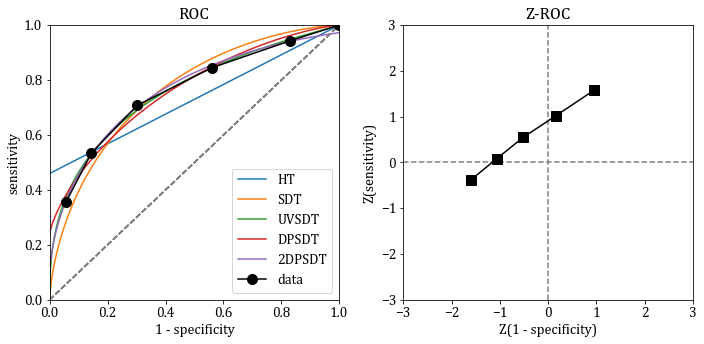

In [8]:
# After this we can make a plot
fig, ax = plt.subplots(1,2, figsize=(10,5))
HT.plot(ax=ax[0]) # specify whether to plot observed data as well
SDT.plot(ax=ax[0])
UVSDT.plot(ax=ax[0])
DPSDT.plot(ax=ax[0])
dDPSDT.plot(ax=ax[0])

ax[0].plot(noise_roc, signal_roc, marker='o', c='k', markersize=10, label='data')
data_AUC = auc(signal_roc, noise_roc)
print(f"Data AUC: {data_AUC}") # AUC calculated using trapezoid method, haven't looked at gini stuff.

ax[1].axhline(0, ls='dashed', c='gray'); ax[1].axvline(0, ls='dashed', c='gray')
ax[1].plot(noise_z, signal_z, marker='s', c='k', markersize=10)
ax[1].set_xlim(-3,3); ax[1].set_ylim(-3,3)
ax[1].set_title('Z-ROC')

ax[0].set_ylabel('sensitivity')
ax[1].set_ylabel('Z(sensitivity)')
ax[0].set_xlabel('1 - specificity')
ax[1].set_xlabel('Z(1 - specificity)')

ax[0].legend()

plt.tight_layout()
plt.show()

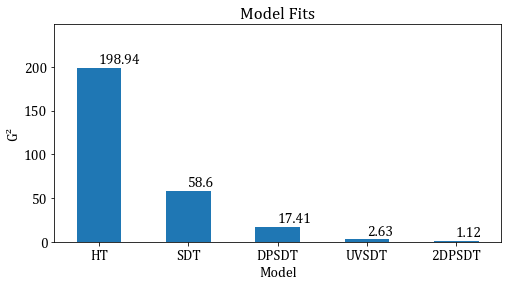

In [9]:
# min(g_values, key=g_values.get) # gets max value from dict without pandas
import pandas as pd
model_performance = pd.Series(g_values).sort_values(ascending=False)
# print(model_performance)
fig, ax = plt.subplots(figsize=(8,4))

model_performance.plot(kind='bar', rot=0, ax=ax)
for i, model in enumerate(zip(model_performance.index, model_performance)):
    g = model[1]
    ax.text(x=i, y=g+5, s=round(g, 2))

ax.set_ylim(0, max(model_performance) * 1.25)
ax.set_ylabel('G\N{SUPERSCRIPT TWO}')
ax.set_xlabel('Model')
ax.set_title('Model Fits')
plt.show()